# Exploring r/redpillwomen submisions and comments

## Libraries & Setup

### Install

In [1]:
%pip install pandas numpy==1.24 matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install bertopic #[spacy]

Note: you may need to restart the kernel to use updated packages.


In [4]:
# %pip install NewsSentiment

In [5]:
%pip install -U sentence-transformers

Note: you may need to restart the kernel to use updated packages.


### Imports

In [6]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [7]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

/Users/tilmankerl/Documents/UNI/SICSS/reddit-pills/.venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tilmankerl/Documents/UNI/SICSS/reddit-pills/.venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tilmankerl/Documents/

### General configs

In [8]:
# matplotlib theme
plt.style.use('ggplot')

### Data loading

In [9]:
# get DATA_DIR
DATA_DIR = os.path.join(Path(os.path.abspath("")).parent, "data")
print(DATA_DIR)

/Users/tilmankerl/Documents/UNI/SICSS/reddit-pills/data


In [10]:
submission_redpill = pd.read_csv(
    f"{DATA_DIR}/output/RedPillWomen_submissions.csv",
    names=["score", "date", "title", 'author_flair_text','link_flair_text','locked','over_18', "author","link", "body"]
)
comments_redpill = pd.read_csv(
    f"{DATA_DIR}/output/RedPillWomen_comments.csv",
    names=["score", "date", "is_submitter", "author","link", "body"]
)

In [11]:
# feature types
submission_redpill.date = pd.to_datetime(submission_redpill.date)
comments_redpill.date = pd.to_datetime(comments_redpill.date)

# introduce month and year columns + month_year column
submission_redpill['month'] = submission_redpill.date.dt.month
submission_redpill['year'] = submission_redpill.date.dt.year
submission_redpill['month_year'] = submission_redpill.date.dt.to_period('M')

In [12]:
print(
    submission_redpill.date.min(),
    submission_redpill.date.max()
)

2013-06-17 00:00:00 2022-12-31 00:00:00


## Exploration

### Submissions

We start our exploraiton by looking into NA values and duplicates.

In [13]:
submission_redpill.head()

,score,date,title,author_flair_text,link_flair_text,locked,over_18,author,link,body,month,year,month_year
0,1,2013-06-18,What's the point of this sub?,NaN,NaN,False,False,u/ienjoyzaandda,https://www.reddit.com/r/RedPillWomen/comments...,NaN,6,2013,2013-06
1,1,2013-06-17,What do you ladies feed your hamsters?,NaN,NaN,False,False,u/lauratheredditor,https://www.reddit.com/r/RedPillWomen/comments...,NaN,6,2013,2013-06
2,2,2013-06-17,How can I get ugly betas to pay for my things ...,NaN,NaN,False,False,u/[deleted],https://www.reddit.com/r/RedPillWomen/comments...,NaN,6,2013,2013-06
3,8,2013-06-17,Suggested Reading List?,Endorsed Woman,NaN,False,False,u/margerym,https://www.reddit.com/r/RedPillWomen/comments...,(I'm new to reddit and the Red Pill community ...,6,2013,2013-06
4,7,2013-06-17,Best way to Convince Man He's the Father?,NaN,NaN,False,False,u/Dramatological,https://www.reddit.com/r/RedPillWomen/comments...,NaN,6,2013,2013-06


In [14]:
# get NAs
submission_redpill.isna().sum()

score                    0
date                     0
title                    0
author_flair_text    20380
link_flair_text      10839
locked                   0
over_18                  0
author                   0
link                     0
body                  1396
month                    0
year                     0
month_year               0
dtype: int64

Plot avergae length of body text

Text(0.5, 1.0, 'Distribution of body text length for submissions')

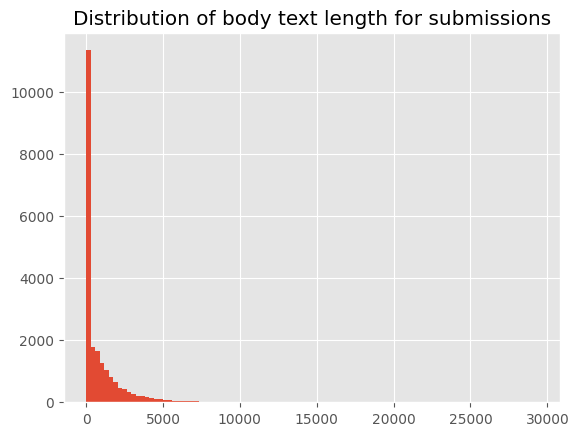

In [15]:
submission_redpill.body.str.len().hist(
    bins=100    
).set_title("Distribution of body text length for submissions")

Plot posts over time:

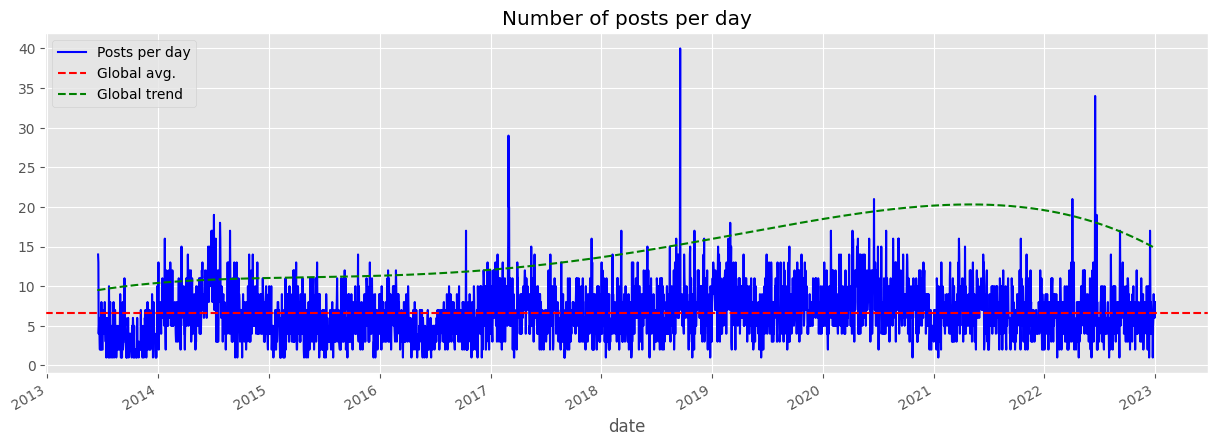

In [16]:
#Plot posts over time:
submission_redpill.date.value_counts().sort_index().plot(
    kind='line',
    title="Number of posts per day",
    figsize=(15, 5),
    # color
    color='b',
)

# add average line
plt.axhline(submission_redpill.date.value_counts().mean(), color='r', linestyle='--')

# convert date to ordinal
submission_redpill['date_ordinal'] = pd.to_datetime(submission_redpill['date']).apply(lambda date: date.toordinal())

# add trend line
z = np.polyfit(submission_redpill['date_ordinal'], submission_redpill['score'], 10)
p = np.poly1d(z)
plt.plot(submission_redpill['date'],p(submission_redpill['date_ordinal']),"g--")

# add legend
plt.legend(['Posts per day', 'Global avg.', 'Global trend'])

Get date with 3-highest number of posts for manual inspection

In [17]:
submission_redpill.groupby('date').count().sort_values(by='author', ascending=False).head(3)

,score,title,author_flair_text,link_flair_text,locked,over_18,author,link,body,month,year,month_year,date_ordinal
date,,,,,,,,,,,,,
2018-09-18,40,40,4,21,40,40,40,40,39,40,40,40,40
2022-06-17,34,34,0,28,34,34,34,34,34,34,34,34,34
2017-03-01,29,29,1,4,29,29,29,29,29,29,29,29,29


Get deleted posts

In [18]:
submission_redpill.body.str.contains('\[deleted\]|\[removed\]').sum()

9136

### Comments

In [19]:
comments_redpill.head()

,score,date,is_submitter,author,link,body
0,2,2017-10-01,False,u/etf42,https://www.reddit.com/r/RedPillWomen/comments...,Men have always been more disposable due to th...
1,1,2017-10-01,False,u/throwawayklutch,https://www.reddit.com/r/RedPillWomen/comments...,"To me, these women seem like they just have no..."
2,2,2017-10-01,False,u/SouthernAthena,https://www.reddit.com/r/RedPillWomen/comments...,That attitude will get them far in life. But y...
3,8,2017-10-01,False,u/platewrecked,https://www.reddit.com/r/RedPillWomen/comments...,"Greg the OP is a suicidal, drug addled, datele..."
4,2,2017-10-01,False,u/thelampshade25,https://www.reddit.com/r/RedPillWomen/comments...,Very funny video i was loling the whole time


Inspecting NAs & drop them

In [20]:
print(comments_redpill.isna().sum())
comments_redpill = comments_redpill.dropna()

score           0
date            0
is_submitter    0
author          0
link            0
body            4
dtype: int64


## Brief Topic modelling using BERTopic

### Processing

Topic-specific preprocessing

In [21]:
submission_redpill_topic = submission_redpill.copy()

print("Before processing:")
print(submission_redpill_topic.shape)

# drop body NAs
submission_redpill_topic = submission_redpill_topic.dropna(subset=['body'])

# drop link duplicates
submission_redpill_topic = submission_redpill_topic.drop_duplicates(subset=['link'])

# remove double spaces & new lines from body
submission_redpill_topic['body'] = submission_redpill_topic['body'].str.replace('\n', ' ')
submission_redpill_topic['body'] = submission_redpill_topic['body'].str.replace('  ', ' ')

# intriduce doc_text column (concat title and body)
submission_redpill_topic['doc_text'] = submission_redpill_topic['title'] + ' ' + submission_redpill_topic['body']
# set dtype to string
submission_redpill_topic['doc_text'] = submission_redpill_topic['doc_text'].astype(str)

# remove delted and removed posts
# check if body is [deleted] or [removed] in one line
submission_redpill_topic = submission_redpill_topic[~submission_redpill_topic['body'].str.contains('\[deleted\]|\[removed\]')]

# based on quantiles, filter out the top and bottom 5% of doc_text length
top_quantile_value = submission_redpill_topic['doc_text'].str.len().quantile(0.95)
print(top_quantile_value)

bottom_quantile_value = submission_redpill_topic['doc_text'].str.len().quantile(0.05)
print(bottom_quantile_value)

# Filter the DataFrame to keep only rows with doc_text length below the 95th percentile
submission_redpill_topic = submission_redpill_topic[submission_redpill_topic['doc_text'].str.len() <= top_quantile_value]
submission_redpill_topic = submission_redpill_topic[submission_redpill_topic['doc_text'].str.len() >= bottom_quantile_value]

# drop duplicates in doc_text
# submission_redpill_topic = submission_redpill_topic.drop_duplicates(subset=['doc_text'])

# remove links from doc_text
url_regex_1 = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
url_regex = r'(?:https?://)?(?:www\.)?[a-zA-Z0-9-]+\.[a-zA-Z]{2,}(?:/[^/\s]*)*'
submission_redpill_topic['doc_text'] = submission_redpill_topic['doc_text'].replace(url_regex, '', regex=True)


print("After processing:")
print(submission_redpill_topic.shape)

Before processing:
(22995, 14)
5152.0
128.0
After processing:
(11223, 15)


Checking if the url regex worked:

In [22]:
print(
    submission_redpill_topic.doc_text.str.contains(url_regex).sum(),
    submission_redpill_topic.doc_text.str.contains("http").sum()
)

0 10


Text(0.5, 1.0, 'Distribution of doc-text length for submissions')

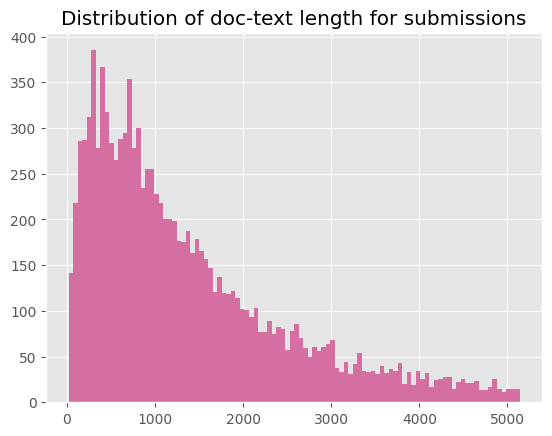

In [57]:
submission_redpill_topic.doc_text.str.len().hist(
    bins=100,
    color="#d56fa2",
).set_title("Distribution of doc-text length for submissions")

Load all titles and bodies as one string in list (one string per post containing title and body)

In [24]:
# Load all titles and bodies as one string in list (one string per post containing title and body)
topic_ready_docs = submission_redpill_topic['doc_text'].tolist()

In [25]:
print(topic_ready_docs[0])

Suggested Reading List? (I'm new to reddit and the Red Pill community so I'm not sure exactly how these things go. I've decided to just jump in. Apologies if I'm overstepping.) I'd love some book recommendations re: Red Pill theory/philosophy as well as the practical aspects of *living* it as a woman; married or otherwise.  As a side but related question: Though I am new to Red Pill itself I was first turned onto the more "old fashioned" way of doing things through Fascinating Womanhood and The Surrendered Wife. Any thoughts on how those two books do or don't relate with the philosophy? Thank you! Margery


### Modelling

In [26]:
representation_model = KeyBERTInspired() 
topic_model = BERTopic(representation_model=representation_model, nr_topics=20) # nr_topics="auto"

In [27]:
# takes 4.5 min for full
topic_model.fit(topic_ready_docs)

In [28]:
topic_model.get_topic_info()    # Get topic words and their probabilities

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5523,-1_relationship_being_am_get,"[relationship, being, am, get, be, love, what,...",[My boyfriend is very beta and I’m starting to...
1,0,2177,0_relationship_sex_boyfriend_being,"[relationship, sex, boyfriend, being, together...",[Mindset is everything: a story about how I’ve...
2,1,881,1_college_dating_advice_relationship,"[college, dating, advice, relationship, be, am...",[Dating is kinda different in my city - need h...
3,2,572,2_women_rpw_pill_men,"[women, rpw, pill, men, woman, sub, her, being...",[The RPW Rules Revisited - Rule Zero In a cont...
4,3,506,3_feminism_men_women_relationship,"[feminism, men, women, relationship, traits, m...","[Buy matching luggage, carry it together Alpha..."
5,4,328,4_fat_healthy_weight_lose,"[fat, healthy, weight, lose, makeup, being, th...",[I'm a teen girl who looks very masculine and ...
6,5,225,5_dinner_recipes_recipe_meal,"[dinner, recipes, recipe, meal, meals, cooking...",[What's for dinner? This is an all inclusive m...
7,6,195,6_self_month_motivated_monthly,"[self, month, motivated, monthly, celebrating,...",[Own Your Stuff It's time for confession y'all...
8,7,187,7_self_care_tending_yourself,"[self, care, tending, yourself, responsibiliti...","[Self Care Taking care of your man, home and f..."
9,8,153,8_dress_dresses_fashion_wardrobe,"[dress, dresses, fashion, wardrobe, dressing, ...",[Worked on my femininity and I have NEVER felt...


In [81]:
for doc in topic_model.get_representative_docs(18):
    print(doc)

Tarot Tuesday: December Happy Tuesday, ladies! (Or Wednesday for the Aussie, Southern Hemisphere Ladies like me) Due to the popularity of the first Tarot post I had, I worked out with the mods to have a Tarot Tuesday held bi-weekly.  **Note:** I apologise for any delay in replies as I have been busy in and out of hospitals as both my family and my SO's family have had emergencies there and I am all over the place until now. Thank you for your patience. So how does it go? &gt;I find that personally the tarot gives a snapshot of situation rather than predicting the future directly and suggests different ways of thinking about or approaching a situation. That's what I believe tarot is about, I also truly enjoy reading for people (if they want) and seeing the tarot give them ideas and fresh perspectives. This is why, after speaking with the mods, I decided to post this and offer just a bit of fun through short, simple (two card or one card) readings to a question **related to your self-imp

In [82]:
topic_label_map = {
    -1: "Baseline relationship issues", 
    0: "relationship issues: sex", 
    1: "Education and Carreer",
    2: "RPW: Philispophy and Meta",
    3: "Gender roles: Alpha/Beta",
    4: "body image",
    5: "Recepies (rec.)",
    6: "personal self improvement (rec.)",
    7: "self care (rec.)",
    8: "Fashion ",
    9: "Flirting",
    10: "sexul experience",
    11: "hair styles",
    12: "body self improvement (rec.)",
    13: "Simple Questions",
    14: "Homemaking (rec.)",
    15: "Music",
    16: "Covid",
    17: "Fertility",
    18: "Tarot Tuesday"
}

In [83]:
topic_model.set_topic_labels(topic_label_map)

In [84]:
topic_model.visualize_barchart()

In [31]:
# submission_redpill_topic["date"].to_list()
topics_over_time_yearly = topic_model.topics_over_time(topic_ready_docs, submission_redpill_topic["year"].to_list())

In [32]:
topics_over_time_monthly = topic_model.topics_over_time(topic_ready_docs, submission_redpill_topic["month_year"].to_list())

In [89]:
topic_model.visualize_topics_over_time(topics_over_time_yearly, topics=list(range(-1, 13)))

In [34]:
monthly_df = topics_over_time_monthly[['Topic', 'Frequency', 'Timestamp']]
# make topic a column and the frequency the value of the cell
monthly_df = monthly_df.pivot(index='Timestamp', columns='Topic', values='Frequency')
monthly_df.fillna(0, inplace=True)

In [35]:
monthly_df

Topic,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Timestamp,,,,,,,,,,,,,,,,,,,,
2013-06,23.0,2.0,2.0,13.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07,55.0,6.0,2.0,16.0,13.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08,37.0,6.0,7.0,11.0,13.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-09,31.0,7.0,5.0,6.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-10,26.0,8.0,0.0,0.0,2.0,0.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08,42.0,27.0,6.0,2.0,3.0,2.0,1.0,0.0,4.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09,59.0,19.0,8.0,6.0,4.0,1.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10,43.0,18.0,3.0,2.0,3.0,0.0,1.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: title={'center': 'Monthly avg. topic mentions'}, xlabel='Date', ylabel='Avg. topic mentions'>

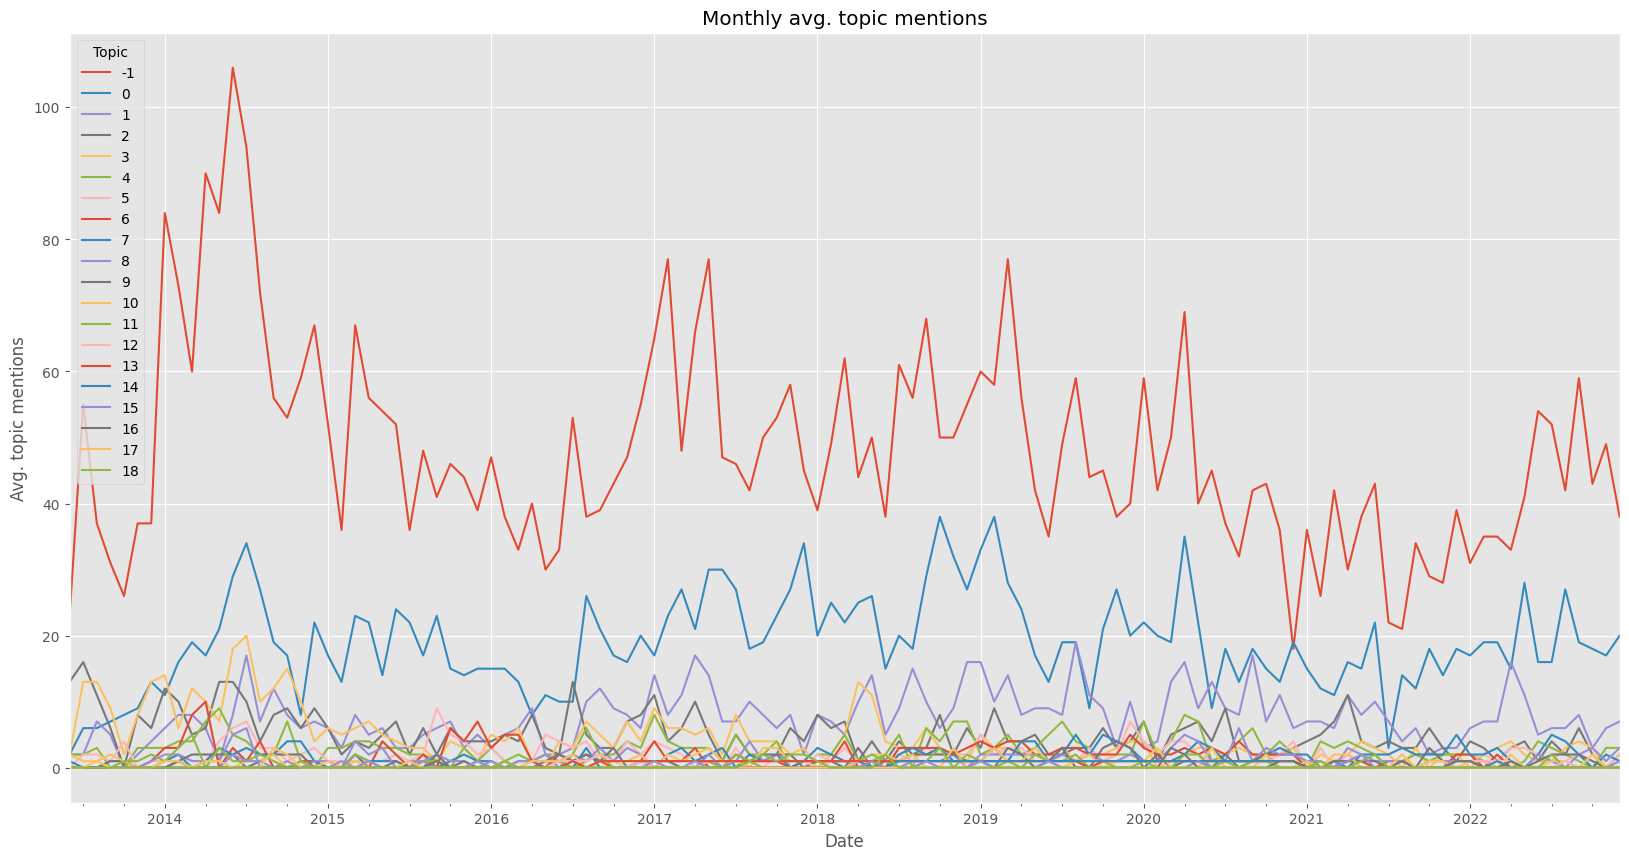

In [36]:
monthly_df.plot(
    kind="line",
    title="Monthly avg. topic mentions",
    xlabel="Date",
    ylabel="Avg. topic mentions",
    figsize=(20, 10),
    legend=True,
)

### Saving & Loading

#### Saving

In [38]:
# Method 1 - safetensors
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("../models/redPillSubmissions-20", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

#### Loading & predicing topics

In [39]:
loaded_model = BERTopic.load("../models/redPillSubmissions-20")

In [42]:
topics, props = loaded_model.transform(topic_ready_docs)

#### Assigning topics & storing

In [85]:
submission_redpill_topic_store = submission_redpill_topic.copy()

submission_redpill_topic_store["topic"] = topics
submission_redpill_topic_store["topic"] = submission_redpill_topic_store["topic"].astype("category")

# using the topic from the mapping topic_label_map
submission_redpill_topic_store["topic_label"] = submission_redpill_topic_store["topic"].map(topic_label_map)

In [86]:
submission_redpill_topic_store.head()

,score,date,title,author_flair_text,link_flair_text,locked,over_18,author,link,body,month,year,month_year,date_ordinal,doc_text,topic,topic_label
3,8,2013-06-17,Suggested Reading List?,Endorsed Woman,NaN,False,False,u/margerym,https://www.reddit.com/r/RedPillWomen/comments...,(I'm new to reddit and the Red Pill community ...,6,2013,2013-06,735036,Suggested Reading List? (I'm new to reddit and...,2,RPW: Philispophy and Meta
5,20,2013-06-17,"What if you don't want kids, but still desire ...",NaN,NaN,False,False,u/alexkitsune,https://www.reddit.com/r/RedPillWomen/comments...,Basically all I see on TRP is all about having...,6,2013,2013-06,735036,"What if you don't want kids, but still desire ...",1,Education and Carreer
7,54,2013-06-17,What's the point if women are going to hit the...,NaN,NaN,False,False,u/MissCherryPi,https://www.reddit.com/r/RedPillWomen/comments...,"According to TRP, men can always build attract...",6,2013,2013-06,735036,What's the point if women are going to hit the...,2,RPW: Philispophy and Meta
13,13,2013-06-17,[Mod] Posting Rules,NaN,NaN,False,False,u/redpillschool,https://www.reddit.com/r/RedPillWomen/comments...,**Posting Submission Rules** * New submissions...,6,2013,2013-06,735036,[Mod] Posting Rules **Posting Submission Rules...,2,RPW: Philispophy and Meta
16,8,2013-06-18,Apparently this is the place I should post,NaN,NaN,False,False,u/myfavoritethrowaway9,https://www.reddit.com/r/RedPillWomen/comments...,I made a post in TRP earlier but someone sugge...,6,2013,2013-06,735037,Apparently this is the place I should post I m...,3,Gender roles: Alpha/Beta


In [95]:
submission_redpill_topic_store.link.head(1)

submission_redpill_topic.link.head(1)

3    https://www.reddit.com/r/RedPillWomen/comments...
Name: link, dtype: object

In [90]:
submission_redpill_topic_store.to_csv('../data/submission_redpill_with_topic.csv', index=False)

### Modelling withoug 'relationship'

In [62]:
# remove "relationship"
submission_redpill_topic_no_relationship = submission_redpill_topic.copy()
submission_redpill_topic_no_relationship['doc_text'] = submission_redpill_topic_no_relationship['doc_text'].str.replace("relationship", '')

topic_ready_docs_no_relationship = submission_redpill_topic_no_relationship['doc_text'].tolist()

In [63]:
representation_model = KeyBERTInspired() 
topic_model_no_no_relationship = BERTopic(representation_model=representation_model, nr_topics=20) # nr_topics="auto"

# takes 4.5 min for full
topic_model_no_no_relationship.fit(topic_ready_docs_no_relationship)

topic_model_no_no_relationship.get_topic_info()    # Get topic words and their probabilities

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5475,-1_am_hes_love_being,"[am, hes, love, being, be, get, what, his, him...",[This is what happens when you can't hold your...
1,0,2367,0_love_advice_together_sex,"[love, advice, together, sex, being, feel, muc...",[Exciting Progress From Communicating! I have ...
2,1,709,1_pill_rpw_women_red,"[pill, rpw, women, red, ladies, woman, her, me...","[Who is Red Pill for, anyway? This may have tu..."
3,2,511,2_feminism_feminist_women_men,"[feminism, feminist, women, men, female, woman...",[Raise your standards – a social and cultural ...
4,3,505,3_dating_be_meet_advice,"[dating, be, meet, advice, feminine, being, so...",[Just be Yourself! There was a question posed ...
5,4,401,4_fat_weight_makeup_lose,"[fat, weight, makeup, lose, body, look, looks,...","[Is waiting the right thing to do? Hello, So ..."
6,5,285,5_self_home_homemaking_house,"[self, home, homemaking, house, domestic, bein...","[Self Care Taking care of your man, home and f..."
7,6,204,6_dinner_recipes_recipe_meal,"[dinner, recipes, recipe, meal, meals, cooking...",[What's for dinner? This is an all inclusive m...
8,7,198,7_month_motivated_monthly_celebrating,"[month, motivated, monthly, celebrating, confe...",[Own Your Stuff It's time for confession y'all...
9,8,175,8_dating_marriage_sex_sexual,"[dating, marriage, sex, sexual, younger, marri...",[Why is lying about your past frowned upon in ...


In [64]:
# safetensors
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("../models/redPillSubmissions-20-wout-relationship", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)